In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import re
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.preprocessing import Normalizer
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold, cross_val_score

import datetime
import matplotlib
from matplotlib import pyplot

In [25]:
prediction_trend_data = [] 
input_numeric_columns = []
input_categorical_columns = []
output_columns = []

normalize = False
dfOriginal = pd.read_csv('../Data/V1.1FeaturesWithLabels20131201To20180430.csv', parse_dates=['Date'], low_memory=False)
df = dfOriginal
all_columns = list(df)
numeric_regex = re.compile("n_*")
input_numeric_columns = list(filter(numeric_regex.match, all_columns))
categorical_regex = re.compile("c_*")                               
input_categorical_columns = list(filter(categorical_regex.match, all_columns))
output_regex = re.compile("o_*")                               
output_columns = list(filter(output_regex.match, all_columns))
metadata_columns = ["Lat", "Lon", "UnifiedRegion", "Date"]
df = df[input_numeric_columns+input_categorical_columns+output_columns+prediction_trend_data+metadata_columns]
    
if(normalize):
    #normalize data; not necessary for xgboost
    scaler = Normalizer()
    dontNormalize = input_categorical_columns + output_columns + prediction_trend_data + metadata_columns
    df.loc[:, ~df.columns.isin(dontNormalize)] = scaler.fit_transform(df.loc[:, ~df.columns.isin(dontNormalize)])

In [26]:
df = df[df['o_Day1DangerAboveTreeline']!='no-data']
df = df[df['o_Day1DangerNearTreeline']!='no-data']
df = df[df['o_Day1DangerBelowTreeline']!='no-data']

df = df[df['o_Day1DangerAboveTreeline']!='Extreme']
df = df[df['o_Day1DangerNearTreeline']!='Extreme']
df = df[df['o_Day1DangerBelowTreeline']!='Extreme']

In [27]:
#clean mising values
mappingMissingValues = {-9999:np.nan}
df = df.replace(mappingMissingValues)
df.head()

,n_f_APCPsurface1HourForecast,n_f_10mWindSpeed1HourForecast,n_f_APCPsurface2HourForecast,n_f_10mWindSpeed2HourForecast,n_f_APCPsurface3HourForecast,n_f_10mWindSpeed3HourForecast,n_f_APCPsurface4HourForecast,n_f_10mWindSpeed4HourForecast,n_f_APCPsurface5HourForecast,n_f_10mWindSpeed5HourForecast,...,o_WindSlab_OctagonBelowTreelineNorthEast,o_WindSlab_OctagonBelowTreelineNorthWest,o_WindSlab_OctagonBelowTreelineSouth,o_WindSlab_OctagonBelowTreelineSouthEast,o_WindSlab_OctagonBelowTreelineSouthWest,o_WindSlab_OctagonBelowTreelineWest,Lat,Lon,UnifiedRegion,Date
0,0.0,0.467704,0.0,1.263505,0.0,1.475613,0.0,1.499958,0.000,1.601572,...,0.0,0.0,0.0,0.0,0.0,0.0,45.325032,-121.768112,Mt Hood,2013-12-11
1,0.0,0.442660,0.0,1.015936,0.0,1.259327,0.0,1.249707,0.000,1.153861,...,0.0,0.0,0.0,0.0,0.0,0.0,45.345059,-121.625313,Mt Hood,2013-12-11
2,0.0,0.821498,0.0,1.296315,0.0,1.545797,0.0,1.576965,0.000,1.661694,...,0.0,0.0,0.0,0.0,0.0,0.0,45.425373,-121.796703,Mt Hood,2013-12-11
3,0.0,1.195470,0.0,0.290174,0.0,1.309988,0.0,1.613151,0.125,1.958329,...,0.0,0.0,0.0,0.0,0.0,0.0,45.825963,-121.911672,Cascade West - South,2013-12-11
4,0.0,1.195470,0.0,0.290174,0.0,1.309988,0.0,1.613151,0.125,1.958329,...,0.0,0.0,0.0,0.0,0.0,0.0,45.825963,-121.911672,Cascade West - South,2013-12-11


In [28]:
splitBySeason = True
yColumns = ['o_Day1DangerAboveTreeline']
yNearColumn = ['o_Day1DangerNearTreeline']
yBelowColumn = ['o_Day1DangerBelowTreeline']

if(splitBySeason):
    df_train = df[df['Date'] < datetime.datetime(2017, 5, 1) ] 
    df_test = df[df['Date'] > datetime.datetime(2017, 5, 1)]
    
    #same x input trained to get a different output
    X_Above_train = X_Near_train = X_Below_train = df_train[input_numeric_columns+input_categorical_columns]
    y_Above_train = df_train[yColumns + metadata_columns]
    y_Near_train = df_train[yNearColumn + metadata_columns]
    y_Below_train = df_train[yBelowColumn + metadata_columns]
    
    X_Above_test = X_Near_test = X_Below_test = df_test[input_numeric_columns+input_categorical_columns]
    y_Above_test = df_test[yColumns + metadata_columns]
    y_Near_test = df_test[yNearColumn + metadata_columns]
    y_Below_test = df_test[yBelowColumn + metadata_columns]
else:
    #random stratified split
    X = df[input_numeric_columns+input_categorical_columns]
    
    yAbove=df[yColumns + metadata_columns]
    X_Above_train, X_Above_test, y_Above_train, y_Above_test = train_test_split(X, yAbove, stratify=yAbove["o_Day1DangerAboveTreeline"], test_size=0.20, random_state=1)
    
    yNear=df[yNearColumn+metadata_columns]
    X_Near_train, X_Near_test, y_Near_train, y_Near_test = train_test_split(X, yNear, stratify=yNear['o_Day1DangerNearTreeline'], test_size=0.20, random_state=1)
    
    yBelow=df[yBelowColumn+metadata_columns]
    X_Below_train, X_Below_test, y_Below_train, y_Below_test = train_test_split(X, yBelow, stratify=yBelow['o_Day1DangerBelowTreeline'], test_size=0.20, random_state=1)

In [29]:
X_Below_train.head()

,n_f_APCPsurface1HourForecast,n_f_10mWindSpeed1HourForecast,n_f_APCPsurface2HourForecast,n_f_10mWindSpeed2HourForecast,n_f_APCPsurface3HourForecast,n_f_10mWindSpeed3HourForecast,n_f_APCPsurface4HourForecast,n_f_10mWindSpeed4HourForecast,n_f_APCPsurface5HourForecast,n_f_10mWindSpeed5HourForecast,...,c_r_Prev3DayWindSlabLikeliness8InPast,c_r_Prev7DayWindSlabLikeliness8InPast,c_r_Prev3DayFreezeThawLikeliness9InPast,c_r_Prev7DayFreezeThawLikeliness9InPast,c_r_Prev3DayWindSlabLikeliness9InPast,c_r_Prev7DayWindSlabLikeliness9InPast,c_r_Prev3DayFreezeThawLikeliness10InPast,c_r_Prev7DayFreezeThawLikeliness10InPast,c_r_Prev3DayWindSlabLikeliness10InPast,c_r_Prev7DayWindSlabLikeliness10InPast
0,0.0,0.467704,0.0,1.263505,0.0,1.475613,0.0,1.499958,0.000,1.601572,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
1,0.0,0.442660,0.0,1.015936,0.0,1.259327,0.0,1.249707,0.000,1.153861,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
2,0.0,0.821498,0.0,1.296315,0.0,1.545797,0.0,1.576965,0.000,1.661694,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
3,0.0,1.195470,0.0,0.290174,0.0,1.309988,0.0,1.613151,0.125,1.958329,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0
4,0.0,1.195470,0.0,0.290174,0.0,1.309988,0.0,1.613151,0.125,1.958329,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0


In [30]:
y_Above_train['o_Day1DangerAboveTreeline'].value_counts()

Moderate        58794
Considerable    47609
High            13923
Low              7258
Name: o_Day1DangerAboveTreeline, dtype: int64

In [7]:
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu')

In [ ]:
%%time
gbmgpu.fit(X_Above_train.values, 
        y_Above_train[yColumns].values.ravel(), 
        eval_set=[(X_Above_test.values, y_Above_test[yColumns].values.ravel())],
        early_stopping_rounds=5
        )

In [12]:
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu')
param_grid = {
    'learning_rate': [0.1],
    'num_leaves': [15, 31, 63, 127, 255, 511, 1023, 2047, 4095]
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(gbmgpu, param_grid, scoring="neg_log_loss", n_jobs=6, cv=kfold, verbose=10)

grid_result = grid_search.fit(X_Above_train.values, y_Above_train[yColumns].values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:   48.2s
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  1.7min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed:  5.0min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 10.0min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 34.3min
[Parallel(n_jobs=6)]: Done  39 out of  45 | elapsed: 111.0min remaining: 17.1min
[Parallel(n_jobs=6)]: Done  45 out of  45 | elapsed: 174.7min finished


Best: -0.094334 using {'num_leaves': 511, 'learning_rate': 0.1}
-0.433086 (0.002184) with: {'num_leaves': 15, 'learning_rate': 0.1}
-0.307489 (0.000903) with: {'num_leaves': 31, 'learning_rate': 0.1}
-0.204446 (0.000706) with: {'num_leaves': 63, 'learning_rate': 0.1}
-0.133307 (0.001184) with: {'num_leaves': 127, 'learning_rate': 0.1}
-0.099393 (0.001245) with: {'num_leaves': 255, 'learning_rate': 0.1}
-0.094334 (0.001332) with: {'num_leaves': 511, 'learning_rate': 0.1}
-0.102743 (0.001108) with: {'num_leaves': 1023, 'learning_rate': 0.1}
-0.112811 (0.001000) with: {'num_leaves': 2047, 'learning_rate': 0.1}
-0.114595 (0.000874) with: {'num_leaves': 4095, 'learning_rate': 0.1}


In [ ]:
%%time
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu')
param_grid = {
    'learning_rate': [0.1],
    'bagging_fraction': [.5, .65, .8],
    'num_leaves': [200, 350, 500],
    'feature_fraction': [.5, .75, 1],
    'reg_alpha': [0, 1, 1.2],
    'reg_lambda': [0, 1, 1.2],
    'class_weight': [None, 'balanced']
}
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=7)
grid_search = GridSearchCV(gbmgpu, param_grid, scoring="neg_log_loss", n_jobs=6, cv=kfold, verbose=10)

grid_result = grid_search.fit(X_Above_train.values, y_Above_train[yColumns].values.ravel())
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Fitting 5 folds for each of 486 candidates, totalling 2430 fits


[Parallel(n_jobs=6)]: Done   1 tasks      | elapsed:  3.8min
[Parallel(n_jobs=6)]: Done   6 tasks      | elapsed:  4.0min
[Parallel(n_jobs=6)]: Done  13 tasks      | elapsed: 11.4min
[Parallel(n_jobs=6)]: Done  20 tasks      | elapsed: 14.9min
[Parallel(n_jobs=6)]: Done  29 tasks      | elapsed: 18.6min
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed: 25.3min
[Parallel(n_jobs=6)]: Done  49 tasks      | elapsed: 34.7min
[Parallel(n_jobs=6)]: Done  60 tasks      | elapsed: 43.4min
[Parallel(n_jobs=6)]: Done  73 tasks      | elapsed: 55.1min
[Parallel(n_jobs=6)]: Done  86 tasks      | elapsed: 64.8min
[Parallel(n_jobs=6)]: Done 101 tasks      | elapsed: 83.6min
[Parallel(n_jobs=6)]: Done 116 tasks      | elapsed: 98.6min
[Parallel(n_jobs=6)]: Done 133 tasks      | elapsed: 115.6min
[Parallel(n_jobs=6)]: Done 150 tasks      | elapsed: 129.1min
[Parallel(n_jobs=6)]: Done 169 tasks      | elapsed: 143.7min
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed: 163.0min
[Parallel(n_jobs=6)]

In [77]:
gbmgpu = lgb.LGBMClassifier(objective='multiclass', device_type='gpu', learning_rate=.05, num_class=4, num_leaves=400, bagging_fraction=.7, class_weight='balanced')

In [78]:
%%time
gbmgpu.fit(X_Above_train.values, 
        y_Above_train[yColumns].values.ravel(), 
        eval_set=[(X_Above_test.values, y_Above_test[yColumns].values.ravel())],
        early_stopping_rounds=10
        )

[1]	valid_0's multi_logloss: 1.36353
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's multi_logloss: 1.34273
[3]	valid_0's multi_logloss: 1.32451
[4]	valid_0's multi_logloss: 1.30804
[5]	valid_0's multi_logloss: 1.29304
[6]	valid_0's multi_logloss: 1.27967
[7]	valid_0's multi_logloss: 1.26795
[8]	valid_0's multi_logloss: 1.25567
[9]	valid_0's multi_logloss: 1.24526
[10]	valid_0's multi_logloss: 1.23411
[11]	valid_0's multi_logloss: 1.22316
[12]	valid_0's multi_logloss: 1.21386
[13]	valid_0's multi_logloss: 1.20517
[14]	valid_0's multi_logloss: 1.19797
[15]	valid_0's multi_logloss: 1.19082
[16]	valid_0's multi_logloss: 1.18316
[17]	valid_0's multi_logloss: 1.1759
[18]	valid_0's multi_logloss: 1.16918
[19]	valid_0's multi_logloss: 1.16266
[20]	valid_0's multi_logloss: 1.15583
[21]	valid_0's multi_logloss: 1.14981
[22]	valid_0's multi_logloss: 1.14392
[23]	valid_0's multi_logloss: 1.13723
[24]	valid_0's multi_logloss: 1.13141
[25]	valid_0's multi_logloss: 1.1268

LGBMClassifier(bagging_fraction=0.7, boosting_type='gbdt',
        class_weight='balanced', colsample_bytree=1.0, device_type='gpu',
        importance_type='split', learning_rate=0.05, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_class=4, num_leaves=400,
        objective='multiclass', random_state=None, reg_alpha=0.0,
        reg_lambda=0.0, silent=True, subsample=1.0,
        subsample_for_bin=200000, subsample_freq=0)

In [79]:
resultAbove = gbmgpu.predict(X_Above_test, gbmgpu.best_iteration_)

In [80]:
gbmgpu.classes_

array(['Considerable', 'High', 'Low', 'Moderate'], dtype=object)

In [81]:
resultAbove[:10]

array([[ 0.73038361, -1.49565303, -0.99718963,  1.58613622],
       [ 0.87682195, -1.49565303, -0.99718963,  1.93601259],
       [ 0.60828886, -1.49565303, -0.99718963,  1.55898034],
       [ 0.61625034, -1.49565303, -0.99718963,  1.72037988],
       [ 0.71717058, -1.49565303, -1.52704939,  1.51997889],
       [ 0.6998328 , -1.36888347, -1.52704939,  1.68993282],
       [ 0.54788454, -1.49565303, -1.52704939,  1.86589826],
       [ 0.84882432, -1.49565303, -1.52660134,  1.55898034],
       [ 0.81942263, -1.49565303, -1.52704939,  1.54713476],
       [ 0.63116509, -1.49565303, -1.52704939,  1.84384003]])

In [82]:
best_preds = [np.argmax(line) for line in resultAbove]

In [83]:
best_preds_df = pd.DataFrame(best_preds, columns=['o_Day1DangerAboveTreeline'])

In [84]:
best_preds_df.head()

,o_Day1DangerAboveTreeline
0,3
1,3
2,3
3,3
4,3


In [85]:
mapping = {0:'Considerable', 1:'High', 2:'Low', 3:'Moderate'}
best_preds_df = best_preds_df.replace({'o_Day1DangerAboveTreeline': mapping})
best_preds_df['o_Day1DangerAboveTreeline'].head()

0    Moderate
1    Moderate
2    Moderate
3    Moderate
4    Moderate
Name: o_Day1DangerAboveTreeline, dtype: object

Accuracy: 0.5405859353488628
Classification Report
              precision    recall  f1-score   support

Considerable       0.51      0.59      0.55     13055
        High       0.33      0.42      0.37      2598
         Low       0.16      0.04      0.07      3330
    Moderate       0.63      0.62      0.62     17335

 avg / total       0.52      0.54      0.53     36318

Normalized confusion matrix
Confusion matrix, without normalization


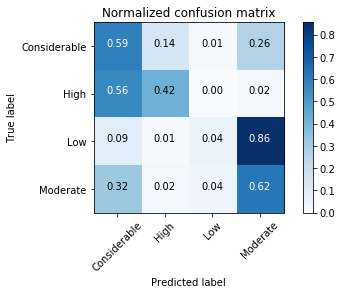

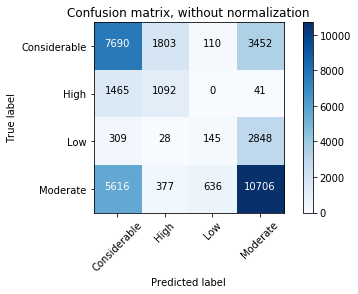

In [86]:
evaluateSingleClassShort(y_Above_test['o_Day1DangerAboveTreeline'], best_preds_df)
cnf_matrix = confusion_matrix(y_Above_test['o_Day1DangerAboveTreeline'], best_preds_df)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'], normalize=True,
                      title='Normalized confusion matrix')
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Considerable', 'High', 'Low', 'Moderate'],
                      title='Confusion matrix, without normalization')
plt.show()

In [23]:
def evaluateSingleClass(y_test, result):
    cm = confusion_matrix(y_test, result)
    print(cm)
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

def evaluateSingleClassShort(y_test, result):
    accuracy = accuracy_score(y_test.values, result)
    print("Accuracy: " + str(accuracy))
    print("Classification Report")
    print(classification_report(y_test.values, result))

#nice confustion matrix plot taken from scikit-learn docs
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [51]:
importances = pd.Series(gbmgpu.feature_importances_)
out = pd.concat([pd.Series(X_Above_train.columns), importances], axis=1)

In [57]:
out.columns = ['feature', 'importance']

In [62]:
out.sort_values('importance',ascending=False)[:100]

,feature,importance
287,n_r_Prev1DayPrecip10InPast,1069
155,n_r_Prev1DayPrecip4InPast,1055
243,n_r_Prev1DayPrecip8InPast,1038
133,n_r_Prev1DayPrecip3InPast,1028
63,n_r_Prev1DayMax10mWind,1012
65,n_r_Prev1DayPrecip,992
89,n_r_Prev1DayPrecip1InPast,966
66,n_f_Next24HourChangeInTempFromPrev3DayMax,964
265,n_r_Prev1DayPrecip9InPast,942
87,n_r_Prev1DayMax10mWind1InPast,919
